In [57]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import numpy as np
import sys
import os

import tensorflow as tf
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath('../'))

import src.utils.ml_util
importlib.reload(src.utils.ml_util)
from src.utils.ml_util import *

import src.utils.trading_util
importlib.reload(src.utils.trading_util)
from src.utils.trading_util import *

In [58]:
TKR = 'SHOP'
MAX_HOLDING = 100
TRAIN_DATE = pd.Timestamp('2022-01-01')
TIME_EFFECT = 3
BLUR_KERNAL_SIZE = 3

historic_prices = yf.download(TKR)['Adj Close']
training_prices = historic_prices[:TRAIN_DATE]
testing_prices = historic_prices[TRAIN_DATE:]

[*********************100%***********************]  1 of 1 completed


Outlook is a function of future returns, weighted less as time progresses

Text(0, 0.5, 'Blurred Normalized Outlook')

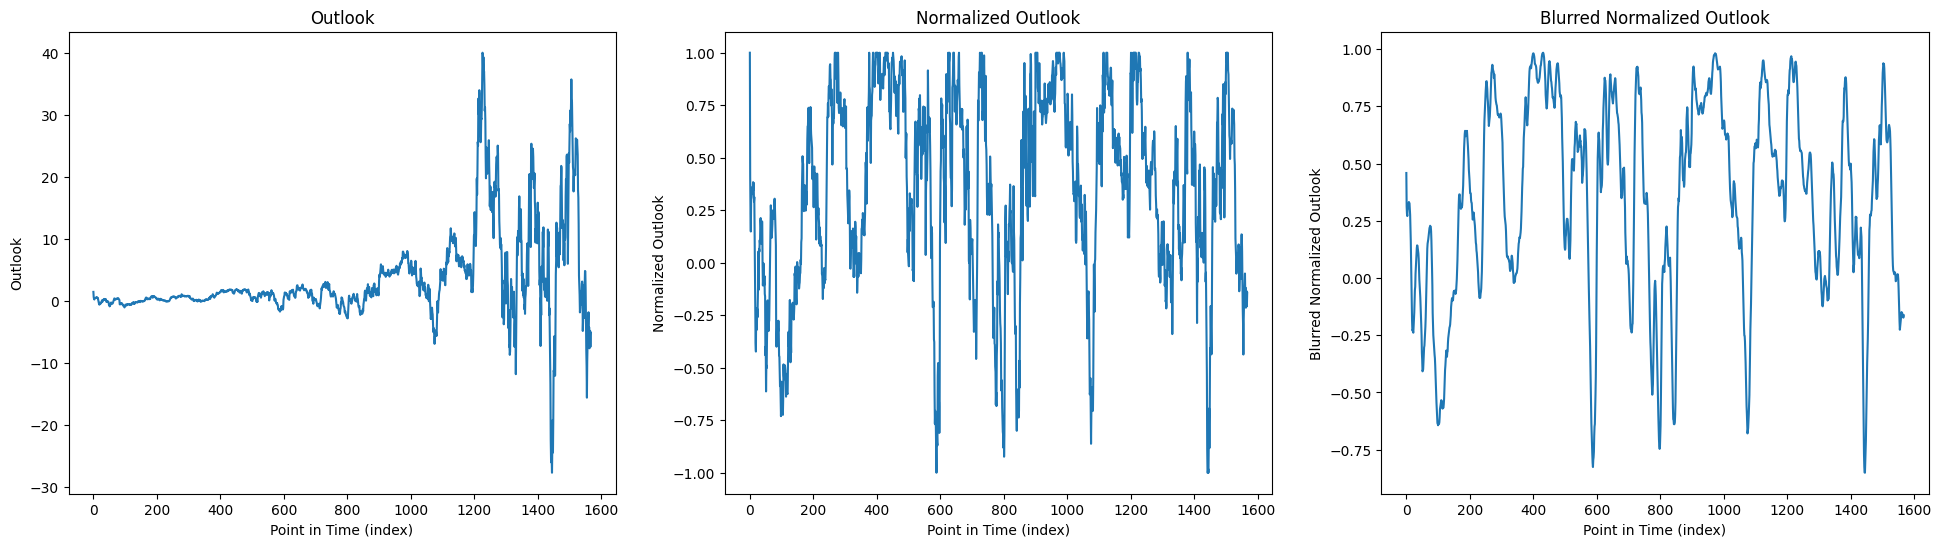

In [ ]:
outlook = []
for pos1 in range(len(training_prices) - MAX_HOLDING):
    ans = 0
    for pos2 in range(1, MAX_HOLDING):
        ans += (training_prices.iloc[pos1 + pos2] - training_prices.iloc[pos1]) * time_effect[TIME_EFFECT](MAX_HOLDING, pos2)
    outlook.append(float(ans.iloc[0] / integrated_time_effect[TIME_EFFECT]))
    
n_outlook = normalize_average(outlook, MAX_HOLDING)
bn_outlook = gaussian_blur(n_outlook, BLUR_KERNAL_SIZE)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

ax1.plot(range(len(outlook)), outlook)
ax1.set_title('Outlook')
ax1.set_xlabel('Point in Time (index)')
ax1.set_ylabel('Outlook')

ax2.plot(range(len(n_outlook)), n_outlook)
ax2.set_title('Normalized Outlook')
ax2.set_xlabel('Point in Time (index)')
ax2.set_ylabel('Normalized Outlook')

ax3.plot(range(len(bn_outlook)), bn_outlook)
ax3.set_title('Blurred Normalized Outlook')
ax3.set_xlabel('Point in Time (index)')
ax3.set_ylabel('Blurred Normalized Outlook')

Text(0, 0.5, 'Gaussian Blurred Price ($)')

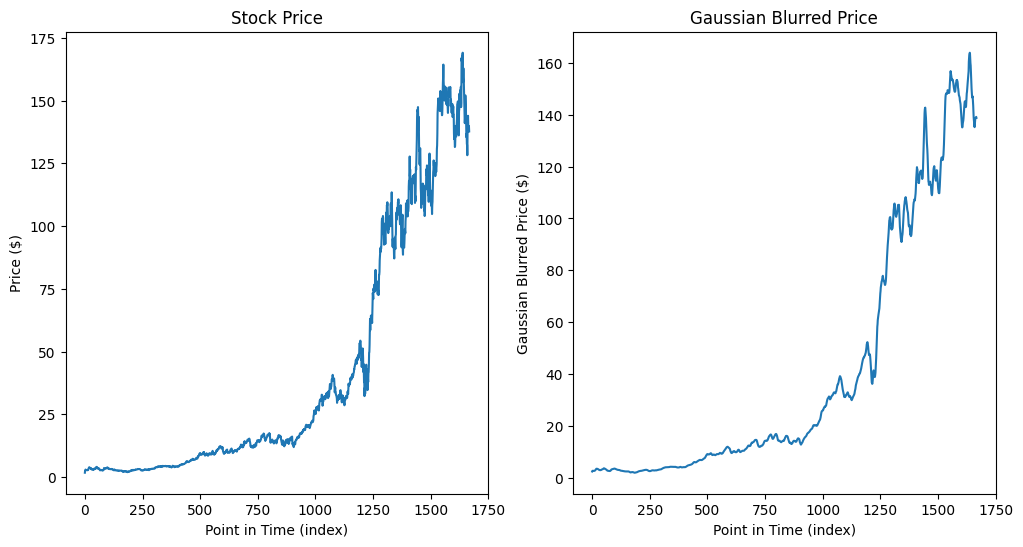

In [ ]:
gaussian_blurred_prices = gaussian_blur(training_prices, BLUR_KERNAL_SIZE)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(training_prices)), training_prices)
ax1.set_title('Stock Price')
ax1.set_xlabel('Point in Time (index)')
ax1.set_ylabel('Price ($)')

ax2.plot(range(len(gaussian_blurred_prices)), gaussian_blurred_prices)
ax2.set_title('Gaussian Blurred Price')
ax2.set_xlabel('Point in Time (index)')
ax2.set_ylabel('Gaussian Blurred Price ($)')

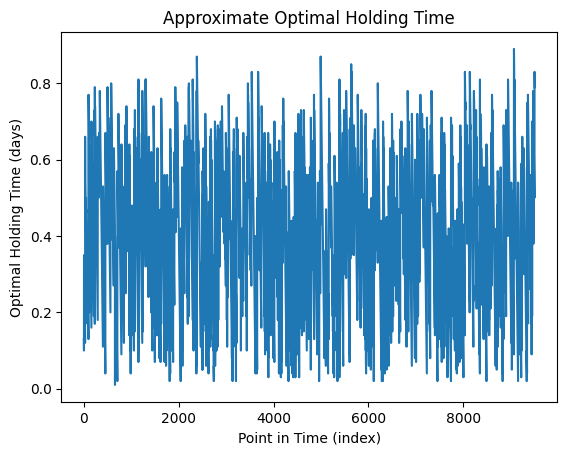

In [6]:
sell_time = []
for day in range(len(training_prices) - MAX_HOLDING):
    if normalized_confidences[day] > 0:
        highest = 0
        highest_pos = 0
        for delay in range(MAX_HOLDING):
            delta = (training_prices.iloc[day + delay] - training_prices.iloc[day]) * time_effect[TIME_EFFECT](MAX_HOLDING, delay)
            if delta > highest:
                highest = delta
                highest_pos = delay
        sell_time.append(highest_pos / MAX_HOLDING)
    else:
        lowest = 0
        lowest_pos = 0
        for delay in range(MAX_HOLDING):
            delta = (training_prices.iloc[day + delay] - training_prices.iloc[day]) * time_effect[TIME_EFFECT](MAX_HOLDING, delay)
            if delta < lowest:
                lowest = delta
                lowest_pos = delay
        sell_time.append(lowest_pos / MAX_HOLDING)

plt.plot(range(len(sell_time)), sell_time)
plt.title('Approximate Optimal Holding Time')
plt.xlabel('Point in Time (index)')
plt.ylabel('Optimal Holding Time (days)')
plt.show()
        

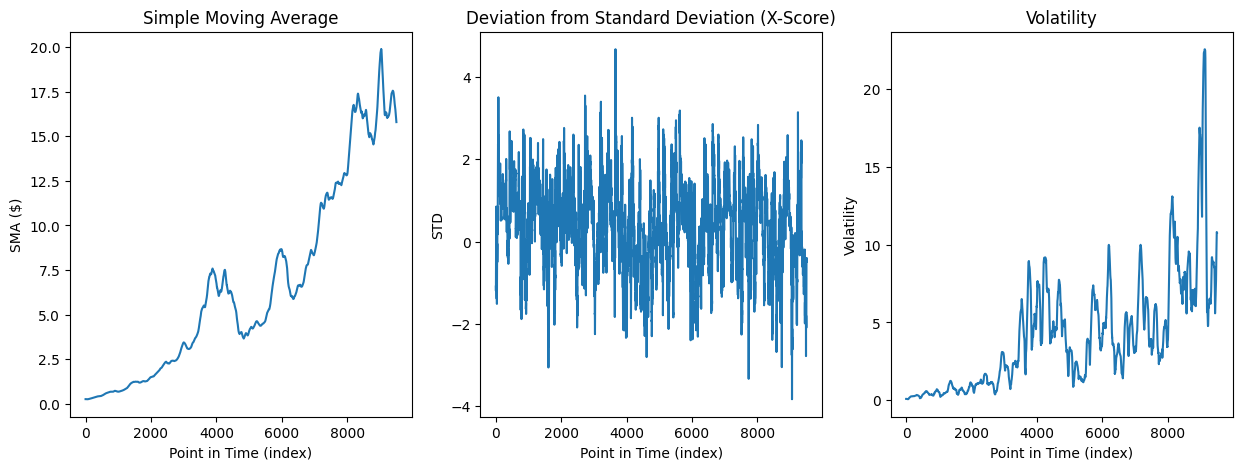

In [7]:
features = get_features(training_prices.tolist(), [5, 10, 20, 50, 70, 100], MAX_HOLDING)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(range(len(features[-3])), features[-3])
axs[0].set_title('Simple Moving Average')
axs[0].set_xlabel('Point in Time (index)')
axs[0].set_ylabel('SMA ($)')
axs[1].plot(range(len(features[-2])), features[-2])
axs[1].set_title('Deviation from Standard Deviation (X-Score)')
axs[1].set_xlabel('Point in Time (index)')
axs[1].set_ylabel('STD')
axs[2].plot(range(len(features[-1])), features[-1])
axs[2].set_title('Volatility')
axs[2].set_xlabel('Point in Time (index)')
axs[2].set_ylabel('Volatility')
plt.show()

In [8]:
for pos in range(len(features)):
    features[pos] = features[pos][:-MAX_HOLDING - 1]
normalized_confidences = normalized_confidences[MAX_HOLDING:]
sell_time = sell_time[MAX_HOLDING:]

x = np.array(transpose(features))
y = np.array(transpose([normalized_confidences, sell_time]))


In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

def create_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(18,)),
        tf.keras.layers.Flatten(name='layers_flatten'),
        tf.keras.layers.Dense(64, activation='tanh'),
        tf.keras.layers.Dense(128, activation='tanh'),
        tf.keras.layers.Dense(256, activation='tanh'),
        tf.keras.layers.Dense(256, activation='tanh'),
        tf.keras.layers.Dense(128, activation='tanh'),
        tf.keras.layers.Dense(64, activation='tanh'),
        tf.keras.layers.Dense(2),
    ])

model = create_model()
model.compile(optimizer='adam',
            loss='mean_absolute_error',)

In [10]:

model.fit(x=x_train, 
        y=y_train, 
        epochs=50, 
        validation_data=(x_test, y_test), 
    )

Epoch 1/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3583 - val_loss: 0.2687
Epoch 2/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2630 - val_loss: 0.2609
Epoch 3/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2573 - val_loss: 0.2654
Epoch 4/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2589 - val_loss: 0.2543
Epoch 5/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2554 - val_loss: 0.2794
Epoch 6/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2575 - val_loss: 0.2555
Epoch 7/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2536 - val_loss: 0.2485
Epoch 8/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2478 - val_loss: 0.2593
Epoch 9/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2526 - val_loss: 0.2546
Epoch 10/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2467 - val_loss: 0.2466
Epoch 11/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2444 - val_loss: 0.2547
Epoch 12/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [11]:
testing_features = np.array(transpose(get_features(testing_prices.tolist(), [5, 10, 20, 50, 70, 100], MAX_HOLDING)))
predictions = model.predict(testing_features)
print(predictions[0])

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[-0.02137127  0.22504285]


In [12]:
account = Account()
stock = Stock(TKR, testing_prices.iloc[0])
MAX_TRANSACTION = 1000

net_worth = []
sell_orders = {}
cover_orders = {}

for pos in range(len(predictions)):

    stock.update_price(testing_prices.iloc[pos])

    if float(predictions[pos][0]) > 0.3:
        account.buy(stock, round(abs((MAX_TRANSACTION / stock.price) * predictions[pos][0]), 3))
        sell_orders[pos + int(predictions[pos][1])] = round(abs((MAX_TRANSACTION / stock.price) * predictions[pos][0]))

    if pos in sell_orders.keys():
        account.sell(stock, sell_orders[pos])

    net_worth.append(account.net_worth())

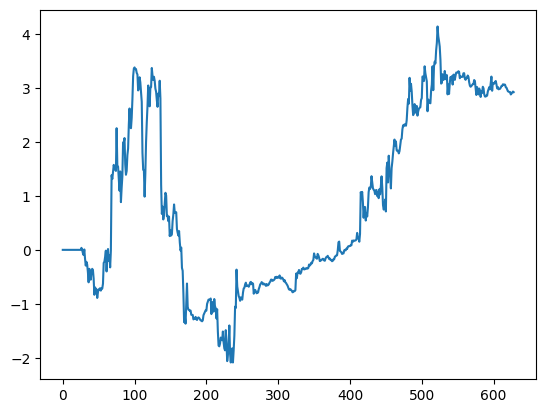

In [13]:
plt.plot(range(len(net_worth)), net_worth)